In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

下面先看看一维的 Ising 模型。每个电子就是一个 agent，电子是 spin-up 为 +1，spin-down 为 0。由于考虑局部模型，所以每个电子的选择只采用其相邻两个电子的状态。所以下面 `get_reward` 函数中，`s` 为相邻电子的列表。

In [3]:
def init_grid(size=(10,)):
    grid = torch.randn(*size)
    grid[grid > 0] = 1
    grid[grid <= 0] = 0
    grid = grid.byte()
    return grid

def get_reward(s, a):
    r = -1
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    return r

In [4]:
size = (20, )
grid = init_grid(size=size)
grid

tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
       dtype=torch.uint8)

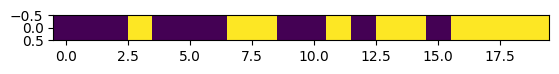

In [7]:
plt.imshow(np.expand_dims(grid, 0))

下面的代码为每一个 agent（也就是电子）创建一个神经网络参数。

In [8]:
def gen_params(N, size):
    ret = []
    for i in range(N):
        vec = torch.randn(size) / 10.
        vec.requires_grad = True
        ret.append(vec)
    return ret

Q 函数使用两层网络，第一层是 $4 \times 20$，第二层是 $20 \times 2$，由于这个 Q 函数接受电子左右电子的联合动作空间状态，左右每个电子的状态可能是 spin-up 或者 spin-down 两种，所以整个空间大小为 $2 \times 2 = 4$，所以第一层的第一维是 4。而输出是当前电子的 spin 对应的 Q 值，spin 只有向上和向下，所以对应 Q 值只有两个，所以网络输出的维度是 2。

In [9]:
def qfunc(s, theta, layers=[(4, 20), (20, 2)], afn=torch.tanh):
    l1n = layers[0]
    l1s = np.prod(l1n)
    theta_1 = theta[0:l1s].reshape(l1n)
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l1s+l2s].reshape(l2n)
    bias = torch.ones((1, theta_1.shape[1]))
    l1 = s @ theta_1 + bias
    l1 = torch.nn.functional.elu(l1)
    l2 = afn(l1 @ theta_2)
    return l2.flatten()

In [10]:
# takes a single binary number and turns it into a one-hot encoded
# action vector like [0, 1]
def get_substate(b):
    s = torch.zeros(2)
    if b > 0:
        s[1] = 1 # [0, 1]
    else:
        s[0] = 1 # [1, 0]
    return s

def joint_state(s):
    s1_ = get_substate(s[0])
    s2_ = get_substate(s[1])
    # creates the joint-action space using the outer-product, then
    # flattens into a vector
    ret = (s1_.reshape(2, 1) @ s2_.reshape(1, 2)).flatten()
    return ret

tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
       dtype=torch.uint8)


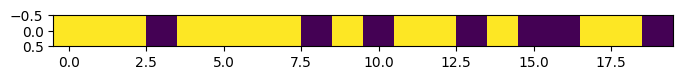

In [12]:
plt.figure(figsize=(8, 5))
size = (20, )
hid_layer = 20
params = gen_params(size[0], 4 * hid_layer + hid_layer * 2)
grid = init_grid(size=size)
grid_ = grid.clone()
print(grid)
plt.imshow(np.expand_dims(grid, 0))

训练主循环如下所示：

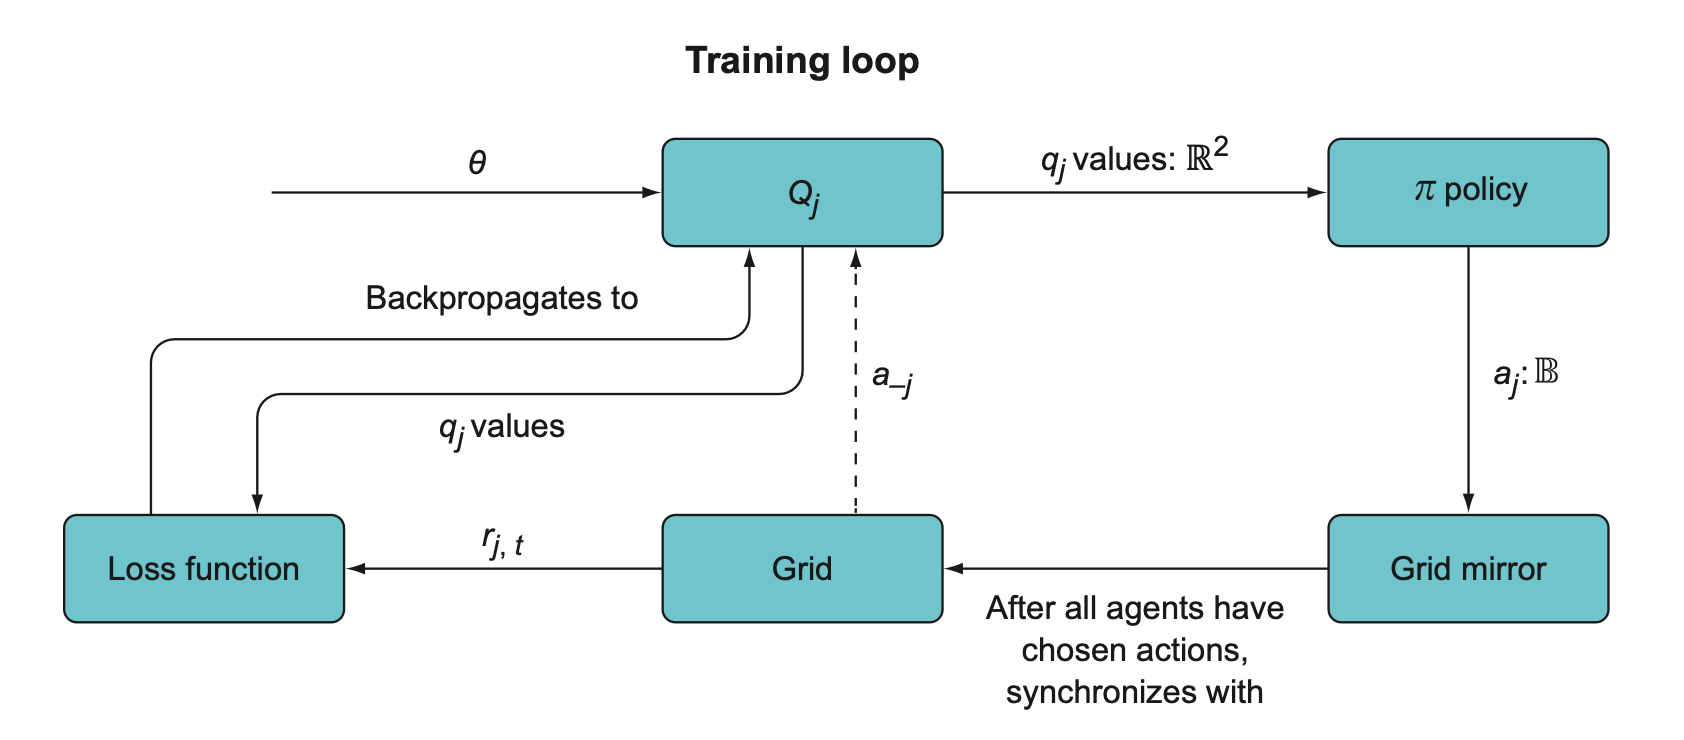

在每个 epoch 里，对于每个 agent（电子），先获取其左右的电子状态，通过 `joint_state` 计算得到联合动作状态，使用这个 agent 对应的 Q 函数计算 Q 值，这个 Q 值是二维的，分别代表 spin-up 与 spin-down，此时只是单纯取收益最大的动作。采取动作（也就是改变电子的 spin）之后，计算 reward，将 qvals 对应动作下标的值改为 reward，然后以这个 reward 作为 target 进行误差计算，反向传播。

In [14]:
epochs = 200
lr = 0.001
losses = [[] for i in range(size[0])]
for i in range(epochs):
    # iterate through all electrons (agents)
    for j in range(size[0]):
        # gets the left and right neighbors
        l = j - 1 if j - 1 >= 0 else size[0] - 1
        r = j + 1 if j + 1 < size[0] else 0

        state_ = grid[[l, r]]
        state = joint_state(state_)
        qvals = qfunc(
            state.float().detach(),
            params[j],
            layers=[(4, hid_layer), (hid_layer, 2)])
        qmax = torch.argmax(qvals, dim=0).detach().item()
        action = int(qmax)
        grid_[j] = action
        reward = get_reward(state_.detach(), action)
        with torch.no_grad():
            target = qvals.clone()
            target[action] = reward
        loss = torch.sum(torch.pow(qvals - target, 2))
        losses[j].append(loss.detach().numpy())
        loss.backward()
        with torch.no_grad():
            params[j] = params[j] - lr * params[j].grad
        params[j].requires_grad = True

    with torch.no_grad():
        grid.data = grid_.data

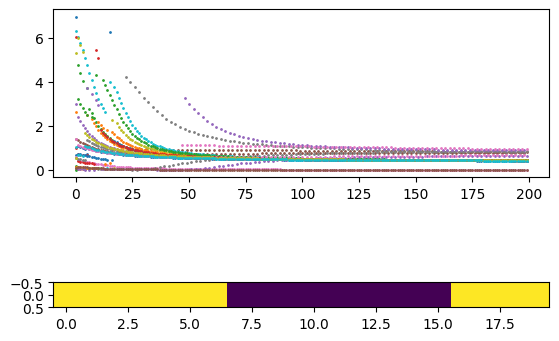

In [17]:
fig, ax = plt.subplots(2, 1)
for i in range(size[0]):
    ax[0].scatter(np.arange(len(losses[i])), losses[i], s=1)
ax[1].imshow(np.expand_dims(grid, 0))

下面解决 2D 的 Ising 模型。

策略选择使用 softmax 函数，其完整定义如下：

$$
P_t(a) = \frac{\exp(q_t(a)/\tau)}{\sum^n_{i=1} \exp(q_t(a)/\tau)}
$$

其中 $P_t(a)$ 是动作的概率分布，$q_t(a)$ 是 Q 值向量。

In [18]:
from collections import deque
from random import shuffle

def softmax_policy(qvals, temp=0.9):
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp))
    action = torch.multinomial(soft, 1)
    return action

In [19]:
def get_coords(grid, j):
    x = int(np.floor(j / grid.shape[0]))
    y = int(j - x * grid.shape[0])
    return x, y

def get_reward_2d(action, action_mean):
    # the reward is based on how different the action is from the mean
    # field action
    r = (action * (action_mean - action/2)).sum() / action.sum()
    # scale the reward to be betwee [-1, +1]
    return torch.tanh(5 * r)

In [20]:
def mean_action(grid, j):
    x, y = get_coords(grid, j)
    action_mean = torch.zeros(2)
    for i in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if i == k == 0:
                continue
            x_, y_ = x + i, y + k
            x_ = x_ if x_ >= 0 else grid.shape[0] - 1
            y_ = y_ if x_ >= 0 else grid.shape[1] - 1
            x_ = x_ if x_ < grid.shape[0] else 0
            y_ = y_ if y_ < grid.shape[1] else 0
            cur_n = grid[x_, y_]
            s = get_substate(cur_n)
            action_mean += s
    action_mean /= action_mean.sum()
    return action_mean

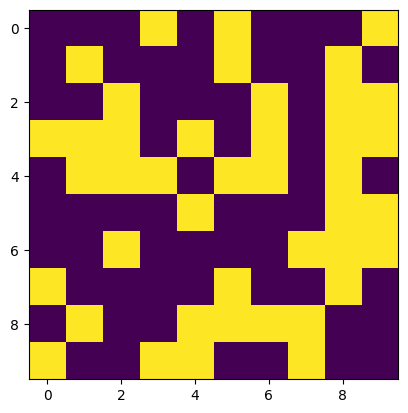

In [21]:
size = (10, 10)
J = np.prod(size)
hid_layer = 10
layers = [(2, hid_layer), (hid_layer, 2)]
params = gen_params(1, 2 * hid_layer + hid_layer * 2)
grid = init_grid(size=size)
grid_ = grid.clone()
grid__ = grid.clone()
plt.imshow(grid)

In [23]:
epochs = 75
lr = 0.00001
num_iter = 3
replay_size = 50
replay = deque(maxlen=replay_size)
batch_size = 10
gamma = 0.9
losses = [[] for i in range(J)]

for i in range(epochs):
    # stores the mean field actions for all the agents
    act_means = torch.zeros((J, 2))
    # stores the Q values for the next state after taking
    # an action
    q_next = torch.zeros(J)
    # since mean fields are initialized randomly, we iterate
    # a few times to dilute the initial randomness
    for i in range(num_iter):
        for j in range(J):
            action_mean = mean_action(grid_, j).detach()
            act_means[j] = action_mean.clone()
            qvals = qfunc(action_mean.detach(), params[0], layers=layers)
            action = softmax_policy(qvals.detach(), temp=0.5)
            grid__[get_coords(grid_, j)] = action
            q_next[j] = torch.max(qvals).detach()
        grid_.data = grid__.data
    grid.data = grid_.data

    actions = torch.stack([get_substate(a.item()) for a in grid.flatten()])
    rewards = torch.stack([get_reward_2d(actions[j], act_means[j]) for j in range(J)])
    
    exp = (actions, rewards, act_means, q_next)
    replay.append(exp)
    shuffle(replay)

    if len(replay) > batch_size:
        ids = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[idx] for idx in ids]
        for j in range(J):
            jacts = torch.stack([ex[0][j] for ex in exps]).detach()
            jrewards = torch.stack([ex[1][j] for ex in exps]).detach()
            jmeans = torch.stack([ex[2][j] for ex in exps]).detach()
            vs = torch.stack([ex[3][j] for ex in exps]).detach()
            qvals = torch.stack([
                qfunc(jmeans[h].detach(), params[0], layers=layers) \
                for h in range(batch_size)])
            
            target = qvals.clone().detach()
            target[:, torch.argmax(jacts, dim=1)] = jrewards + gamma * vs
            loss = torch.sum(torch.pow(qvals - target.detach(), 2))
            losses[j].append(loss.item())
            loss.backward()

            with torch.no_grad():
                params[0] = params[0] - lr * params[0].grad
            params[0].requires_grad = True


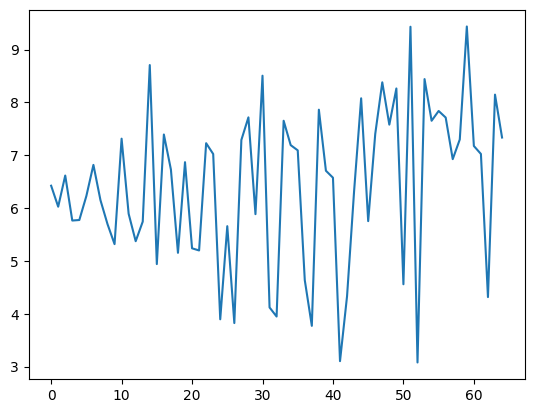

In [26]:
plt.plot(np.array(losses).mean(axis=0))

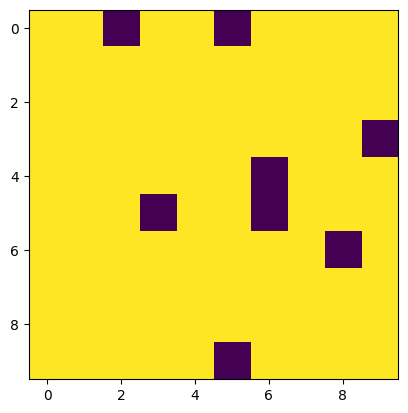

In [25]:
plt.imshow(grid)